<h1 style="color:#3a7aad">Phishing Detection</h1>

In [169]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

<h2 style="color:#3a7aad">Mendeley Data</h2>

In [170]:
from scipy.io import arff

data = arff.loadarff('./Data/Phishing_Legitimate_full.arff')
mendeley_dataframe = pd.DataFrame(data[0])

print(len(mendeley_dataframe))
mendeley_dataframe.head()

10000


,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,3.0,1.0,5.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,-1.0,1.0,b'1'
1,3.0,1.0,3.0,144.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,1.0,1.0,b'1'
2,3.0,1.0,2.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.0,1.0,-1.0,0.0,b'1'
3,3.0,1.0,6.0,79.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,1.0,-1.0,b'1'
4,3.0,0.0,4.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,-1.0,0.0,-1.0,-1.0,b'1'


In [171]:
print(mendeley_dataframe.columns)

Index(['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
       'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
       'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperlinksRT

In [172]:
X = mendeley_dataframe.drop(columns=['CLASS_LABEL'])
y = mendeley_dataframe['CLASS_LABEL'].apply(lambda x: int(x))

# X.head()
# Y.head()

<h3 style="color:#3a7aad">Train-test split</h3>

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<h3 style="color:#3a7aad">Feature Selection</h3>

<AxesSubplot:>

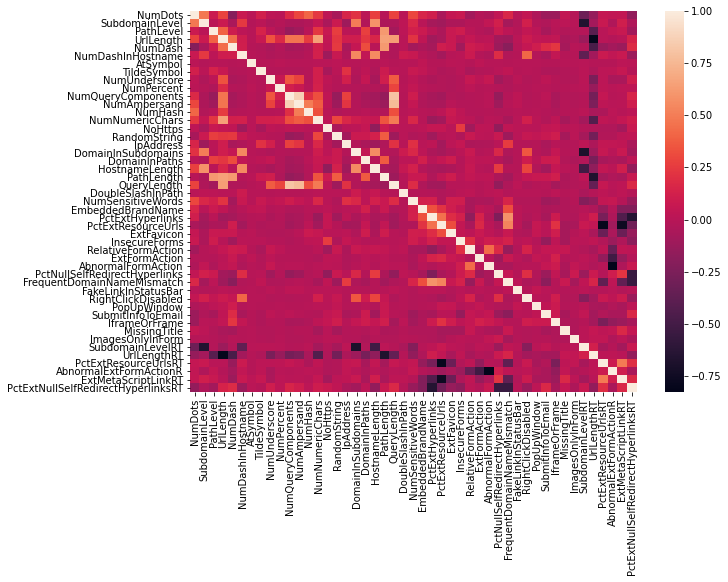

In [174]:
%matplotlib inline
f, ax = plt.subplots(figsize=(10, 7))
# calculate the correlation matrix
corr = X_train.drop(columns=['HttpsInHostname']).corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [175]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_train, y_train, 5)
print(str(len(cor_feature)), 'selected features')
print(' ')
print(cor_feature)

5 selected features
 
['PctNullSelfRedirectHyperlinks', 'SubmitInfoToEmail', 'NumDash', 'FrequentDomainNameMismatch', 'PctExtNullSelfRedirectHyperlinksRT']


/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ahmadchaiban/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [176]:
X_features_kept = X[cor_feature]

<h3 style="color:#3a7aad">t-SNE</h3>

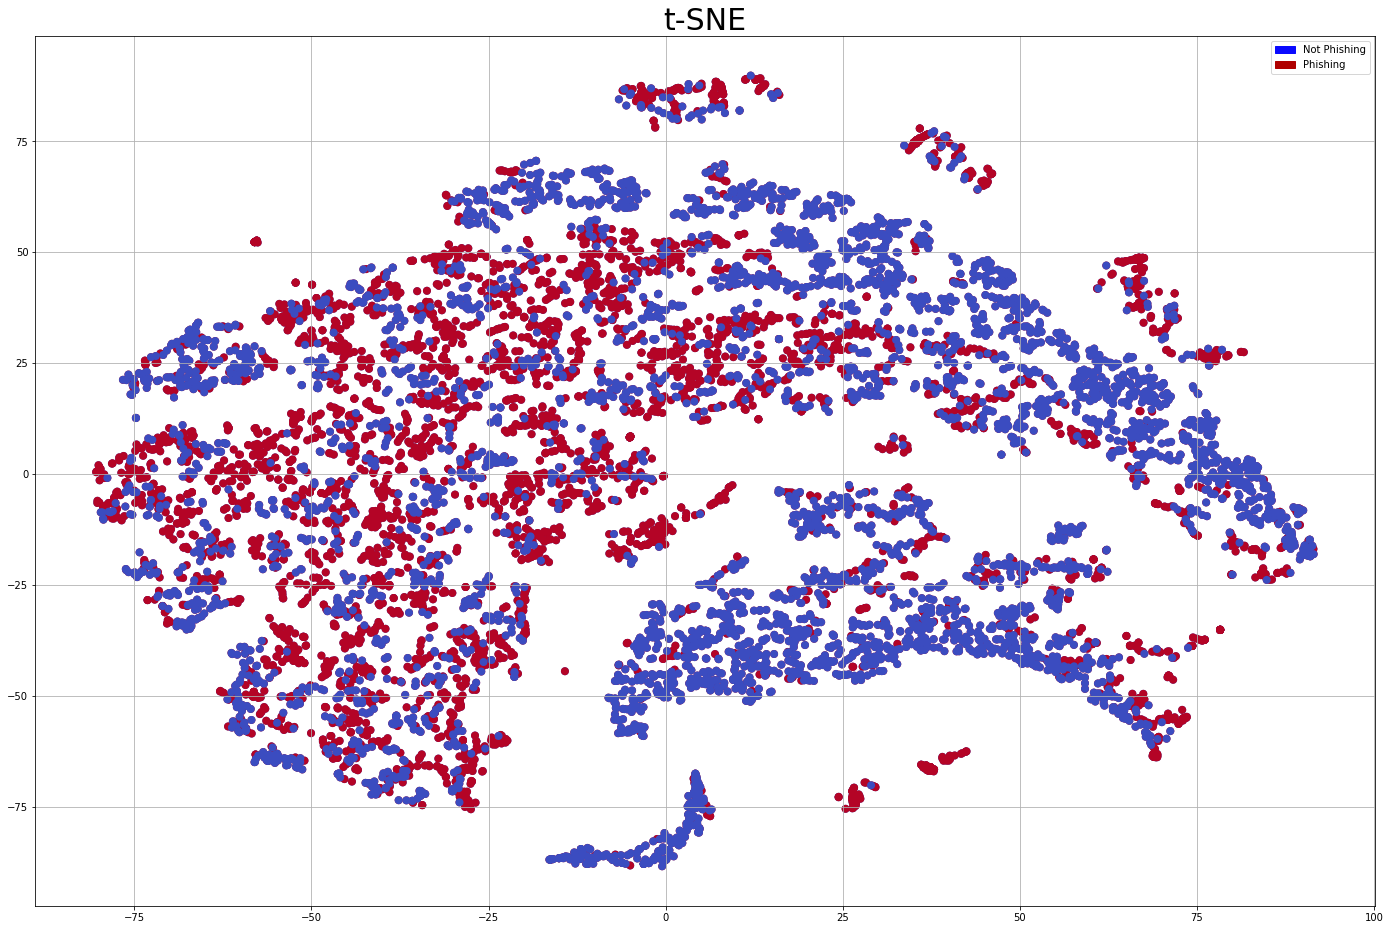

In [177]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

X_embedded = TSNE(n_components = 2, random_state = 0).fit_transform(X)


f, ax = plt.subplots(figsize=(24,16))

blue_patch = mpatches.Patch(color='#0A0AFF', label='Not Phishing')
red_patch = mpatches.Patch(color='#AF0000', label='Phishing')

ax.scatter(X_embedded[:,0], X_embedded[:,1], c=(y == 0), cmap='coolwarm', label='Not Phishing', linewidths=2)
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=(y == 1), cmap='coolwarm', label='Phishing', linewidths=2)
ax.set_title('t-SNE', fontsize=30)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

<h3 style="color:#3a7aad">t-SNE After Feature Selection</h3>

In [178]:
X_embedded_fs = TSNE(n_components = 2, random_state = 0).fit_transform(X_features_kept)

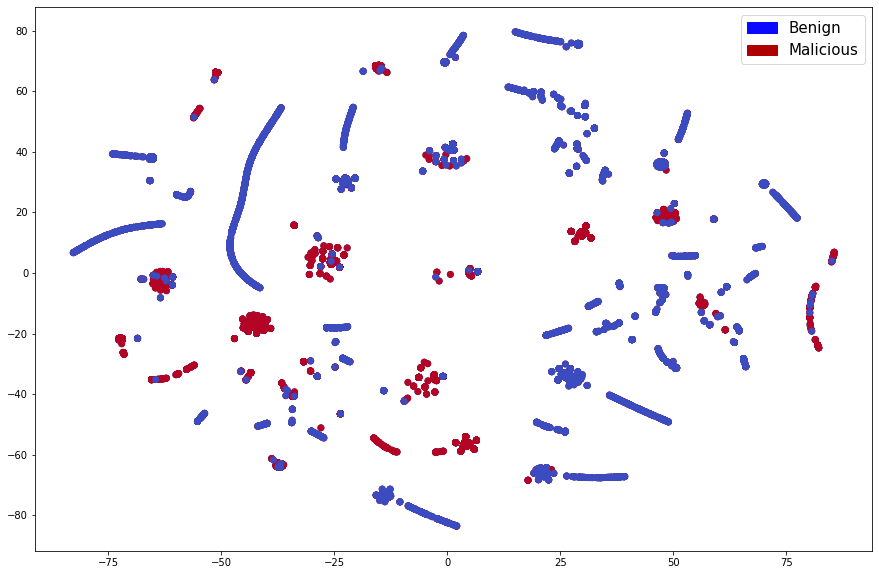

In [179]:
f, ax = plt.subplots(figsize=(15,10))

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

ax.scatter(X_embedded_fs[:,0], X_embedded_fs[:,1], c=(y == 0), cmap='coolwarm', label='Benign', linewidths=1)
ax.scatter(X_embedded_fs[:,0], X_embedded_fs[:,1], c=(y == 1), cmap='coolwarm', label='Malicious', linewidths=1)
# ax.set_title('t-SNE', fontsize=14)

# ax.grid(False)

# ax.axis('off')

# ax.set_xticks([])
# ax.set_yticks([])

ax.legend(handles=[blue_patch, red_patch], fontsize=15)

In [180]:
X_embedded_3d_fs = TSNE(n_components = 3, random_state = 0).fit_transform(X_features_kept)

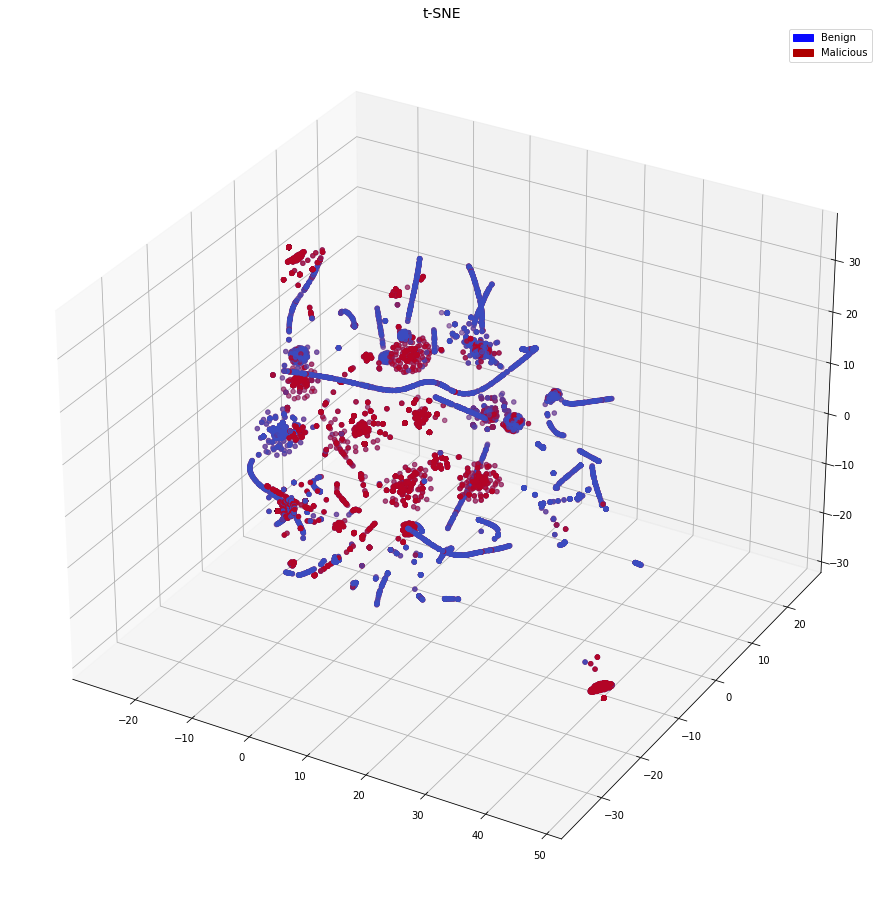

In [181]:
fig = plt.figure(figsize = (24,16))
ax = fig.add_subplot(111, projection='3d')

blue_patch = mpatches.Patch(color='#0A0AFF', label='Benign')
red_patch = mpatches.Patch(color='#AF0000', label='Malicious')

ax.scatter(X_embedded_3d_fs[:,0], 
           X_embedded_3d_fs[:,1], 
           X_embedded_3d_fs[:,2], c=(y == 0), 
           cmap= 'coolwarm', label='Benign', linewidths=1)
ax.scatter(X_embedded_3d_fs[:,0], 
           X_embedded_3d_fs[:,1], 
           X_embedded_3d_fs[:,2], c=(y == 1), 
           cmap='coolwarm', label='Malicious', linewidths=1)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

<h3 style="color:#3a7aad">Malicious and Benign websites data from Kaggle</h3>

In [182]:
MBW_data = pd.read_csv('./Data/dataset.csv')
MBW_data.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [183]:
MBW_data.columns

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

<h2 style="color:#3a7aad">Train-test split</h2>

In [184]:
X = MBW_data.drop(columns=['Type'])
y = MBW_data['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<h2 style="color:#3a7aad">Feature Selection</h2>

<AxesSubplot:>

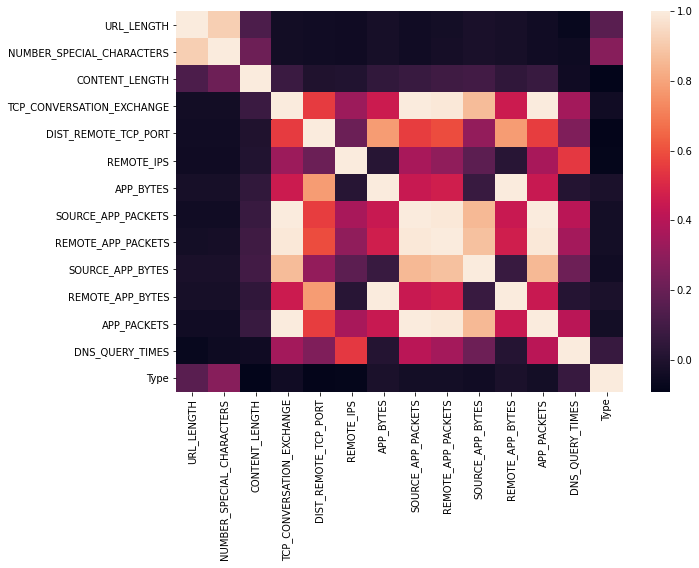

In [185]:
%matplotlib inline

f, ax = plt.subplots(figsize=(10, 7))

# calculate the correlation matrix
corr = MBW_data.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [186]:
sorted_features = X_train.corr().abs().unstack().sort_values(kind='quicksort')
sorted_features

REMOTE_IPS                 CONTENT_LENGTH               0.000118
CONTENT_LENGTH             REMOTE_IPS                   0.000118
                           DIST_REMOTE_TCP_PORT         0.000800
DIST_REMOTE_TCP_PORT       CONTENT_LENGTH               0.000800
DNS_QUERY_TIMES            APP_BYTES                    0.002117
                                                          ...   
TCP_CONVERSATION_EXCHANGE  TCP_CONVERSATION_EXCHANGE    1.000000
CONTENT_LENGTH             CONTENT_LENGTH               1.000000
NUMBER_SPECIAL_CHARACTERS  NUMBER_SPECIAL_CHARACTERS    1.000000
APP_PACKETS                APP_PACKETS                  1.000000
DNS_QUERY_TIMES            DNS_QUERY_TIMES              1.000000
Length: 169, dtype: float64